# Implementing Convolutional Neural Network (CNN) with Tensorflow

## Identyfy handwritten digits in MNIST dataset. 

Implement CNN with two convolutional layers to identyfy handwritten digits. 

In [1]:
# Make it work with python2 as well
from __future__ import print_function, division
from builtins import range

# Needed imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

### MNIST dataset

MNIST ("Modified National Institute of Standards and Technology") dataset

This dataset contains handwritten images of digits 0 to 9. The digits have been size-normalized and centered in a fixed-size image  (28x28). Was released in 1999 and it serves as the basis for benchmarking classification algorithms. 

In [2]:
mnist = tf.keras.datasets.mnist

(XtrainOrig, YtrainOrig),(XtestOrig, YtestOrig) = mnist.load_data()


### Display Samples from dataset

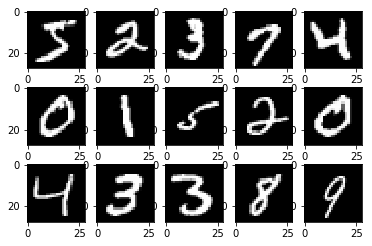

XtrainOrig.shape = (60000, 28, 28) 		YtrainOrig.shape = (60000,)
XtestOrig.shape = (10000, 28, 28) 		YtestOrig.shape = (10000,)


In [3]:
f, axarr = plt.subplots(3, 5)
for i in range(3):
    for j in range(5):
        axarr[i, j].imshow(XtrainOrig[i + 5*j], cmap='gray')
plt.show()

print("XtrainOrig.shape =", XtrainOrig.shape, "\t\tYtrainOrig.shape =", YtrainOrig.shape)
print("XtestOrig.shape =", XtestOrig.shape, "\t\tYtestOrig.shape =", YtestOrig.shape)


### Prepare dataset for learning

Reshape the vector to add dimention for color channel. Here we have only one color channel. 
Then convert the pixel values in range 0 to 1 (float).

In [4]:
# H - Hight of image, W - Width of image
# N - Number of samples
# so, D is also number of nodes in the input layer.
Ntr, H, W = XtrainOrig.shape
Ntt = XtestOrig.shape[0]
C = 1 # Number of color channels

Xtrain = XtrainOrig.reshape(Ntr, H, W, C)
Xtest = XtestOrig.reshape(Ntt, H, W, C)

Ytrain, Ytest = YtrainOrig, YtestOrig

# Divide by 255.0
Xtrain, Xtest = Xtrain / 255.0, Xtest / 255.0


# Convert columar indicator vector to binary indicator matrix.
# Ex. Y = [2, 1, 0]
# return T = [[0, 0, 1], [0, 1, 0], [1, 0, 0]]
def conv_indicator_to_matrix(Y, numClasses):
    N = len(Y)
    T = np.zeros((N, numClasses))
    for i in range(N):
        T[i, int(Y[i])] = 1
    return T

# Number of Catagories
numCatag = 10

Ytrain_ind = conv_indicator_to_matrix(YtrainOrig, numCatag).astype(np.float32)
Ytest_ind = conv_indicator_to_matrix(YtestOrig, numCatag).astype(np.float32)

print("Xtrain.shape =", Xtrain.shape, "\t\tYtrain_ind.shape =", Ytrain_ind.shape)
print("Xtest.shape =", Xtest.shape, "\t\tYtest_ind.shape =", Ytest_ind.shape)


Xtrain.shape = (60000, 28, 28, 1) 		Ytrain_ind.shape = (60000, 10)
Xtest.shape = (10000, 28, 28, 1) 		Ytest_ind.shape = (10000, 10)


### Defining the Convolutional Neural Network (CNN) with two convolutional layers

In [5]:
# Number of nodes in output layer
# This is equal to number of catagories in the data
K = numCatag
M = 300 # Number of nodes in fully connected layer
# Pool size for max pooling
poolsz = (2, 2)


def initFilter(shape, poolsz):
    w = np.random.randn(*shape) * np.sqrt(2.0 / np.prod(shape[:-1]))
    # w = np.random.randn(*shape) * np.sqrt(2) / np.sqrt(np.prod(shape[:-1]) 
    #     + shape[-1]*np.prod(shape[:-2]) / np.prod(poolsz))
    return w.astype(np.float32)

C1_FilterWidth, C1_FilterHight = 3, 3
C1_NumFeatureMaps = 20
C1_OutWidth = W // poolsz[0]  # Devide for pooling
C1_OutHight = H // poolsz[1]  # Devide for pooling
#C1_OutWidth = (H - (C1_FilterWidth -1)) / poolsz[0]  # Devide for pooling
#C1_OutHight = (H - (C1_FilterHight -1)) / poolsz[1]  # Devide for pooling

C2_FilterWidth, C2_FilterHight = 3, 3
C2_NumFeatureMaps = 50
C2_OutWidth = C1_OutWidth // poolsz[0]  # Devide for pooling
C2_OutHight = C1_OutHight // poolsz[1]  # Devide for pooling
#C2_OutWidth = (C1_OutWidth - (C2_FilterWidth -1)) / poolsz[0]  # Devide for pooling
#C2_OutHight = (C1_OutHight - (C2_FilterHight -1)) / poolsz[1]  # Devide for pooling

# Initial weights and bias for convolutional layers
W1_shape = (C1_FilterWidth, C1_FilterHight, C, C1_NumFeatureMaps)
W1_init = initFilter(W1_shape, poolsz)
b1_init = np.zeros(W1_shape[-1], dtype=np.float32) # one bias per output feature map

W2_shape = (C2_FilterWidth, C2_FilterHight, C1_NumFeatureMaps, C2_NumFeatureMaps)
W2_init = initFilter(W2_shape, poolsz)
b2_init = np.zeros(W2_shape[-1], dtype=np.float32)

# Initial weights and bias for fully connected layer
W3_inSize = C2_NumFeatureMaps * C2_OutWidth * C2_OutHight
W3_init = np.random.randn(W3_inSize, M) / np.sqrt(W3_inSize + M)
b3_init = np.zeros(M, dtype=np.float32)
W4_init = np.random.randn(M, K) / np.sqrt(M + K)
b4_init = np.zeros(K, dtype=np.float32)


# Define placeholders for inputs.
#thY = T.matrix('Y')
tfX = tf.placeholder(tf.float32, shape=(None, H, W, C), name='X')
tfY = tf.placeholder(tf.float32, shape=(None, K), name='Y')

# Variable for neural network weights. These are updated by Tensorflow during training.
# These weights are learned during training.
W1 = tf.Variable(W1_init.astype(np.float32), name="W1")
b1 = tf.Variable(b1_init.astype(np.float32), name="b1")
W2 = tf.Variable(W2_init.astype(np.float32), name="W2")
b2 = tf.Variable(b2_init.astype(np.float32), name="b2")
W3 = tf.Variable(W3_init.astype(np.float32), name="W3")
b3 = tf.Variable(b3_init.astype(np.float32), name="b3")
W4 = tf.Variable(W4_init.astype(np.float32), name="W4")
b4 = tf.Variable(b4_init.astype(np.float32), name="b4")

def convpool(X, W, b, psz):
    # just assume pool size is (2,2) because we need to augment it with 1s
    conv_out = tf.nn.conv2d(X, W, strides=[1, 1, 1, 1], padding='SAME')
    conv_out = tf.nn.bias_add(conv_out, b)
    pool_out = tf.nn.max_pool(conv_out, ksize=[1, psz[0], psz[1], 1], strides=[1, psz[0], psz[1], 1], padding='SAME')
    return tf.nn.relu(pool_out)

Z1 = convpool(tfX, W1, b1, poolsz)
Z2 = convpool(Z1, W2, b2, poolsz)
Z2_shape = Z2.get_shape().as_list()
Z2r = tf.reshape(Z2, shape=[-1, np.prod(Z2_shape[1:])])
Z3 = tf.nn.relu( tf.matmul(Z2r, W3) + b3 )
Y_bar = tf.matmul(Z3, W4) + b4 # In Tensorflow, the cost function includes the softmax, so not needed here.



lr = 0.001
reg = 0.01

# define the cost function and prediction
# softmax_cross_entropy_with_logits take in the "logits"
# if we wanted to know the actual output of the neural net,
# we can pass "Y_bar" into tf.nn.softmax(logits)
cost = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Y_bar, labels=tfY))
# cost = tf.reduce_sum(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=Y_bar,labels=tfY))

# we don't implement the learning algorithm ourselves.
# We use the RMSprop optimizer provided by Tensorflow. It includes momentum as well.
train_op = tf.train.RMSPropOptimizer(lr, decay=(1-reg), momentum=0.9).minimize(cost)

# We'll use this to calculate the error rate
predict_op = tf.argmax(Y_bar, 1)


### Training the neural network with Stochastic Gradient Descent

Batch gradient descent computes the gradient using the whole dataset. This is great for convex, or relatively smooth error manifolds. In this case, we move somewhat directly towards an optimum solution, either local or global. Additionally, batch gradient descent, given an annealed learning rate, will eventually find the minimum located in it's basin of attraction.

Stochastic gradient descent (SGD) computes the gradient using a single sample. Most applications of SGD actually use a minibatch of several samples. SGD works well for error manifolds that have lots of local maxima/minima. In this case, the somewhat noisier gradient calculated using the reduced number of samples tends to jerk the model out of local minima into a region that hopefully is more optimal. Single samples are really noisy, while minibatches tend to average a little of the noise out.
Thus, the amount of jerk is reduced when using minibatches. A good balance is struck when the minibatch size is small enough to avoid some of the poor local minima, but large enough that it doesn't avoid the global minima or better-performing local minima. Generally, the best minima have a larger and deeper basin of attraction, and are therefore easier to fall into. One benefit of SGD is that it's computationally a whole lot faster. Large datasets often can't be held in RAM, which makes vectorization much less efficient. Rather, each sample or batch of samples must be loaded, worked with, the results stored, and so on. Minibatch SGD, on the other hand, is usually intentionally made small enough to be computationally tractable. Usually, this computational advantage is leveraged by performing many more iterations of SGD, making many more steps than conventional batch gradient descent. This usually results in a model that is very close to that which would be found via batch gradient descent, or better.

The way to think of how SGD works is to imagine that we have one point that represents input distribution. The model is attempting to learn that input distribution. Surrounding the input distribution is a shaded area that represents the input distributions of all of the possible minibatches we could sample. It's usually a fair assumption that the minibatch input distributions are close in proximity to the true input distribution. Batch gradient descent, at all steps, takes the steepest route to reach the true input distribution. SGD, on the other hand, chooses a random point within the shaded area, and takes the steepest route towards this point. At each iteration, though, it chooses a new point. The average of all of these steps will approximate the true input distribution, usually quite well. Thanks to Jason L Bens.



Cost / err at epoch 0:	 41303.391 / 0.831
Cost / err at epoch 1:	 710.070 / 0.022
Cost / err at epoch 2:	 557.046 / 0.019
Cost / err at epoch 3:	 540.667 / 0.017
Cost / err at epoch 4:	 604.995 / 0.018
Cost / err at epoch 5:	 594.971 / 0.017
Cost / err at epoch 6:	 481.267 / 0.012
Cost / err at epoch 7:	 579.674 / 0.016
Cost / err at epoch 8:	 554.075 / 0.015
Cost / err at epoch 9:	 638.025 / 0.017


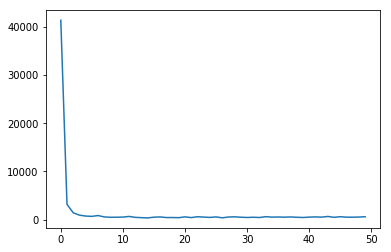

Prediction error with test set = 0.0145


In [6]:
def error_rate(p, t):
    return np.mean(p != t)

max_iter = 10
print_period = 25
batch_sz = 500
n_batches = Ntr // batch_sz

#t0 = datetime.now()

costs = []
init = tf.global_variables_initializer()
with tf.Session() as session:
    session.run(init)
    
    for epoch in range(max_iter):
        first = 1
        for j in range(n_batches):
            Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
            Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]

            session.run(train_op, feed_dict={tfX: Xbatch, tfY: Ybatch})

            # Compute cost on test set to see the learning progress
            if j % print_period == 0:
                test_cost = session.run(cost, feed_dict={tfX: Xtest, tfY: Ytest_ind})
                prediction = session.run(predict_op, feed_dict={tfX: Xtest})
                err = error_rate(prediction, Ytest)
                costs.append(test_cost)
                if first:
                    first = 0
                    print("Cost / err at epoch %d:\t %.3f / %.3f" % (epoch, test_cost, err))


    plt.plot(costs)
    plt.show()

    prediction_val = session.run(predict_op, feed_dict={tfX: Xtest})
    err = error_rate(prediction_val, Ytest)
    print("Prediction error with test set =", err)
